In [8]:
from typing import List, Dict, Set, Tuple, Optional
import numpy as np
import cv2
import random
import copy
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Path

import elkai
from tsp_solver.greedy import solve_tsp
from python_tsp.exact import solve_tsp_dynamic_programming
import time 


In [31]:
class TwoOpt(Path):
    def __init__(self,
        image: np.ndarray,
        patch_size: Tuple[int,int],
        start: int,
        iteration: int = 1,
        threshold: float = 0.01,
        verbose: Optional[bool] = True):
            
        super().__init__(image,patch_size,verbose)
        self.start = start
        self.iteration = iteration
        self.threshold = threshold
        self.history = [[]for _ in range(self.iteration)]

    def get_statistics(self):
        """
        Plot the statistics of two-opt
        """
        self.history = np.asarray(self.history)
        plt.figure(figsize=(15,10))
        ax = plt.subplot(111)
        for i in range(self.iteration):
            ax.plot(np.arange(self.history.shape[1]),self.history[i,:],label=f"route {i}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0+box.height*0.1,box.width,box.height*0.9]) # shrink axis height by 10%
        ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.05),fancybox=True,shadow=True,ncol=self.iteration//2)
        ax.set_title("Two Opt")
        ax.set_ylabel("Distance")
        ax.set_xlabel("Iteration")
        plt.show()

    def initialize(self):
        route = [self.start]
        route += random.sample(range(1,self.num_vertex), self.num_vertex-1)
        
        return route

    def swap(self,path, i, j):
        path_updated = path[0:i+1] + path[j:-len(path)+i:-1] + path[j+1:]
        return path_updated
    
    def two_opt(self,
                route:List[int],
                num_iteration: Optional[int] = None,
                ):
        """
        iteration: Number of iterations to perform 2-opt
        fast: Selects the first improving move or the best 
        """
        iteration = 0
        for i in range(1, self.num_vertex-1): 
            for j in random.sample(list(range(i+1,self.num_vertex-1)), self.num_vertex-i-2):
                x1 = route[i]
                x2 = route[i+1]
                y1 = route[j]
                y2 = route[j+1]
                before = self.weight_matrix[x1][x2] + self.weight_matrix[y1][y2]
                after = self.weight_matrix[x1][y1] + self.weight_matrix[x2][y2]
                if after < before:
                    route = self.swap(route, i, j)
                # self.history[curr_iteration].append(len(self.build_path(route)))

            if not (num_iteration == None):
                if iteration == num_iteration:
                    return route
                else:
                    iteration += 1
            
        return route

    def _optimize(self):
        self.seal_path = []
        self.traverse_path = []
        self.all_path_converted = []   
        for i, g in enumerate(self.all_graphs):
            route = self.initialize()
            path = self.two_opt(route)
            path = self.build_path(path,self.adj_list,self.local_to_coords)
            self.seal_path.append(path)

        if len(self.seal_path) == 1:
            p = [self.mapping_r[local_node] for local_node in self.seal_path[0]]
            self.all_path_converted.append(p)
            return p
        
        else:
            path = []
            path_weights, connect_paths = self.post_path(self.seal_path)
            path_weights[:,0] = 0
            crack_order, _ = solve_tsp_dynamic_programming(path_weights)
            self.all_path_converted = []        

            for i in range(len(self.all_graphs)):
                path_converted = []
                path_converted = list(map(lambda x : self.mapping_r[x], self.seal_path[i]))
                self.all_path_converted.append(path_converted)

            path = []
            for i in range(len(self.all_path_converted)-1):
                path.extend(self.all_path_converted[i])
                traverse_path = connect_paths[(i,i+1)]
                path.extend(traverse_path)
                self.traverse_path.append(traverse_path)

            path.extend(self.all_path_converted[crack_order[-1]])

            return path


Preprocessing of graph completed
[1174, 1175, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1377, 1378, 1438, 1439, 1379, 1378, 1377, 1317, 1316, 1376, 1375, 1374, 1314, 1315, 1314, 1313, 1253, 1252, 1251, 1250, 1251, 1252, 1312, 1313, 1312, 1311, 1310, 1309, 1308, 1307, 1367, 1366, 1306, 1305, 1304, 1303, 1302, 1301, 1241, 1242, 1241, 1240, 1300, 1299, 1239, 1238, 1237, 1236, 1235, 1175, 1235, 1295, 1296, 1297, 1298, 1297, 1296, 1295, 1294, 1234, 1233, 1232, 1231, 1230, 1229, 1230, 1231, 1232, 1292, 1293, 1292, 1291, 1290, 1289, 1229, 1228, 1288, 1287, 1288, 1348, 1347, 1346, 1345, 1346, 1406, 1405, 1404, 1464, 1463, 1462, 1402, 1403, 1402, 1401, 1461, 1401, 1400, 1460, 1400, 1399, 1398, 1397, 1396, 1397, 1457, 1458, 1457, 1456, 1455, 1395, 1394, 1454, 1514, 1513, 1512, 1452, 1453, 1452, 1451, 1391, 1390, 1450, 1449, 1389, 1388, 1387, 1386, 1385, 1384, 1383, 1384, 1444, 1443, 1442, 1441, 

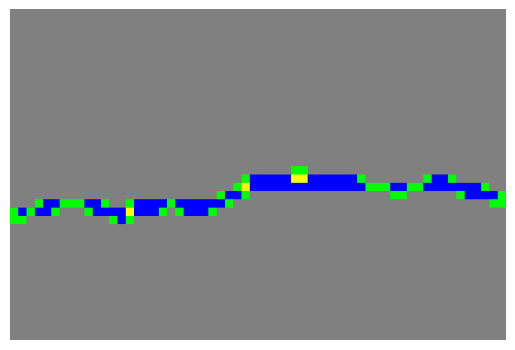

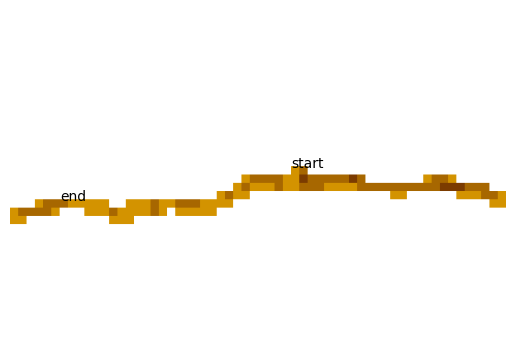

In [32]:
if __name__ == "__main__":

    img = cv2.imread("./binary_image/4.png",cv2.IMREAD_UNCHANGED) 
    ps = (8,8)
    x = TwoOpt(img,ps,0,1,0.01,True)
    path = x._optimize()  
    print(path)
    print(x.num_vertex)
    print(x.check_all_path())
    # x.get_statistics()